<a href="https://colab.research.google.com/github/lsvedula/corise-r-for-ds/blob/main/Estimating_Age_from_Name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> __DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.__


## What's in a Name? - Estimating Age from Name

![shakespeare-whats-in-a-name](https://miro.medium.com/v2/resize:fit:800/1*Prp8tivsOP54c-bPTpxj5A.png)

So, what more is in a name? Well, with some further work, it is possible to predict the age of a person based on the name (Whoa! Really????). The popular FiveThirtyEight published a [blog post](https://fivethirtyeight.com/features/how-to-tell-someones-age-when-all-you-know-is-her-name/) on this in 2014. Would it not be fun to try and replicate the results? Actually, we are going to do more than just replicate the results, since we now have 7 years worth of additional data.

![estimate-age-from-name](https://fivethirtyeight.com/wp-content/uploads/2014/05/silver-feature-most-common-women-names3.png)

⚠️ __Install Packages: This can take a couple of minutes. So be patient!__


In [13]:
pkgs <- c("Hmisc", "janitor", "zoo")
options(repos = c(CRAN = "https://packagemanager.rstudio.com/cran/latest"))
install.packages(pkgs)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘snakecase’




### Import Data

#### Names

Let us start by reading in the babynames data from `data/names.csv.gz`.

In [3]:
# Load the tidyverse package
library(tidyverse)

# Read data_url into a data frame named `tbl_names`
data_url <- "https://github.com/ramnathv/corise-r-for-ds/raw/main/data/names.csv.gz"
tbl_names <- readr::read_csv(
  data_url
)

# Print head of tbl_names
tbl_names

Rows: 2052781 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, sex
dbl (2): year, nb_births

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,name,sex,nb_births
<dbl>,<chr>,<chr>,<dbl>
1880,Mary,F,7065
1880,Anna,F,2604
1880,Emma,F,2003
1880,Elizabeth,F,1939
1880,Minnie,F,1746
1880,Margaret,F,1578
1880,Ida,F,1472
1880,Alice,F,1414
1880,Bertha,F,1320


In [ ]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.device = 'svg+xml')
ggplot2::theme_set(ggplot2::theme_gray(base_size = 16))

#### Lifetables

In order to estimate age from a person's name, we will additionally need actuarial data that can tell us the chances that someone is still alive, based on when they were born. Fortunately, the SSA provides detailed 
[actuarial life tables](https://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_6_1990.html) by birth cohorts for the US.

| year| age|      qx|    lx|  dx|    Lx|      Tx|    ex|sex |
|----:|---:|-------:|-----:|---:|-----:|-------:|-----:|:---|
| 1910|  39| 0.00283| 78275| 222| 78164| 3129636| 39.98|F   |
| 1910|  40| 0.00297| 78053| 232| 77937| 3051472| 39.09|F   |
| 1910|  41| 0.00318| 77821| 248| 77697| 2973535| 38.21|F   |
| 1910|  42| 0.00332| 77573| 257| 77444| 2895838| 37.33|F   |
| 1910|  43| 0.00346| 77316| 268| 77182| 2818394| 36.45|F   |
| 1910|  44| 0.00351| 77048| 270| 76913| 2741212| 35.58|F   |

The key column of interest to us is `lx`, which provides the number of people born in a year who live up to a given age. The probability of being alive can be derived as `lx` by 100,000. You can read the documentation for the lifetables to understand what the other columns mean. 

How do we get this data in R? There are no CSV files to download. The data is on the website of the SSA as an HTML table. Moreover, the data for different years are on different pages. This is a very common situation you will find yourself in as a data scientist.

Fortunately, R and the `tidyverse` has an excellent set of packages that make it easy to scrape data from the web programmatically and bring them into R as a table. This goes beyond the scope of this course and so I have simply included the code I used to scrape this data.


In [4]:
read_lifetable <- function(year) {
  url <- glue::glue(
    "https://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_6_{year}.html"
  )
  # Extract raw lifetable for year
  lifetable <- xml2::read_html(url) |> 
    # Read ALL html tables
    rvest::html_table(header = FALSE) |> 
    # Extract the second table in the list
    magrittr::extract2(2) |> 
    # Slice the first and third rows off
    slice(-c(1, 3))
  
  # Extract columns for male (1:7) and female (9:15) and stack them
  col_names <- c(unlist(lifetable[1, 1:6], use.names = F), 'ex')
  tibble(sex = c("M", "F"), cols = list(1:7, 9:15)) |> 
    mutate(table = purrr::map2(sex, cols, ~ {
      lifetable |> 
        slice(-1) |> 
        select(all_of(.y)) |> 
        set_names(nm = col_names)
    })) |> 
    select(!cols) |> 
    unnest(table) |> 
    filter(x != "") |> 
    rename(age = x) |> 
    mutate(across(!sex, parse_number))
}

read_lifetables <- function() {
  tibble(year = seq(1900, 2100, by = 10)) |> 
    mutate(lifetable = purrr::map(year, read_lifetable)) |> 
    tidyr::unnest(lifetable)
}

# tbl_lifetables <- read_lifetables()

We already ran the code above and saved the data as `data/lifetables.csv.gz`. Let us read it into a table named `tbl_lifetables`.

In [8]:
# Read data/lifetables.csv.gz into a data frame named `tbl_lifetables`
file_name_lifetables <- "https://github.com/ramnathv/corise-r-for-ds/raw/main/data/lifetables.csv.gz"
# Read file_name_lifetables into a data frame named `tbl_lifetables`
tbl_lifetables <- read_csv(file_name_lifetables)

# Print head of `tbl_lifetables`
tbl_lifetables

Rows: 5040 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): sex
dbl (8): year, age, qx, lx, dx, Lx, Tx, ex

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,sex,age,qx,lx,dx,Lx,Tx,ex
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1900,M,0,0.14596,100000,14596,90026,4640595,46.41
1900,M,1,0.03814,85404,3257,83776,4550569,53.28
1900,M,2,0.01958,82147,1608,81343,4466793,54.38
1900,M,3,0.01353,80539,1090,79994,4385450,54.45
1900,M,4,0.01080,79449,858,79020,4305456,54.19
1900,M,5,0.00794,78591,624,78279,4226436,53.78
1900,M,6,0.00570,77967,444,77745,4148156,53.20
1900,M,7,0.00407,77523,316,77365,4070411,52.51
1900,M,8,0.00305,77207,235,77090,3993046,51.72


It is always a good idea to plot the data to understand it better. Given that this is a table of probabilities of survival, let us plot the survival curve for a person to be alive in 2022 based on the year they were born.

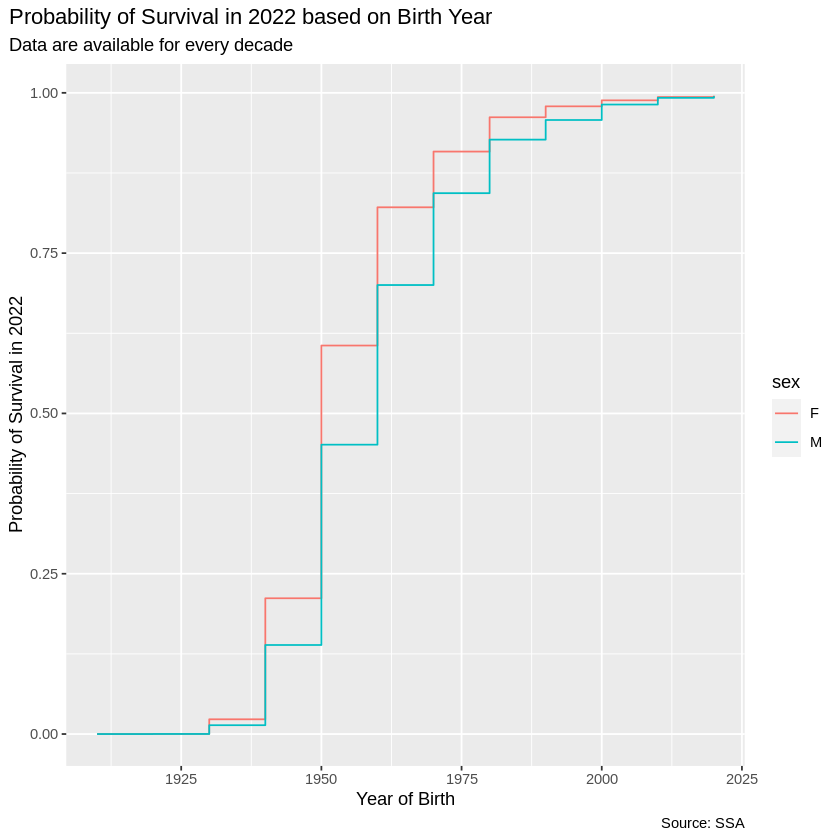

In [20]:
tbl_lifetables |> 
  # Filter for rows where age and year sum up to 2022
  filter(year + age == 2022) |> 
  # Initialize a ggplot of year vs. probability of being alive (lx/10^5)
  ggplot(aes(x = year, y = lx/10^5, color = sex)) +
  # Add a step layer
  geom_step() +
  # Add labels (title, subtitle, x, y, caption)
  labs(
    title = "Probability of Survival in 2022 based on Birth Year",
    subtitle = "Data are available for every decade",
    x = "Year of Birth",
    y = "Probability of Survival in 2022",
    caption = "Source: SSA"
  ) +
  # Update theme to move plot title
  theme(plot.title.position = 'plot')

Looking at the plot, we gather that a male born in 1950 has almost a 50% chance of being alive in 2022. Notice that `tbl_lifetable` only has entries for every decade. In order to figure out the distribution of people alive, we need the probabilities for every year. One way to fill up the gaps in the data is to use some kind of interpolation. We will extend the lifetable by adding the full sequence of years for every `sex` and `age` combination, and then extrapolating the data to compute `lx` for the newly added combinations. 

### Transform Data

#### Manipulate Data

We can extend the lifetables this by using three useful functions:

1. `full_seq`: Creates a full sequence of values in a vector.
2. `complete`: Completes a data frame with missing combinations.
3. `na.spline`: Replace `NA` with interpolated values using cubic interpolation.

Given that we want to interpolate for all combinations of `sex` and `age`, we first need to group by `sex` and `age`, then use `complete` and `full_seq` to add the missing combinations, and finally `zoo::na.approx` to interpolate the `NA` values using cubic interpolation. We will `ungroup` the data at the end as the grouping is no longer necessary.

In [14]:
tbl_lifetables_extended <- tbl_lifetables |> 
  # Select the columns sex, age, year, and lx
  select(sex, age, year, lx) |>
  # Group by sex and age
  group_by(sex, age) |>
  # Complete the sequence of years
  complete(year = full_seq(year, period = 1)) |> 
  # Add a NEW boolean column to indicate if the data is imputed
  mutate(is_imputed = is.na(lx)) |> 
  # Interpolate missing values using zoo::na.approx
  mutate(lx = zoo::na.approx(lx)) |> 
  # Ungroup the data
  ungroup()

head(tbl_lifetables_extended)

sex,age,year,lx,is_imputed
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
F,0,1900,1e+05,FALSE
F,0,1901,1e+05,TRUE
F,0,1902,1e+05,TRUE
F,0,1903,1e+05,TRUE
F,0,1904,1e+05,TRUE
F,0,1905,1e+05,TRUE


We can get the probability that a person has survived till 2022 by filtering `tbl_lifetables_extended` for rows where `year + age = 2022`.

List of 1
 $ plot.title.position: chr "plot"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

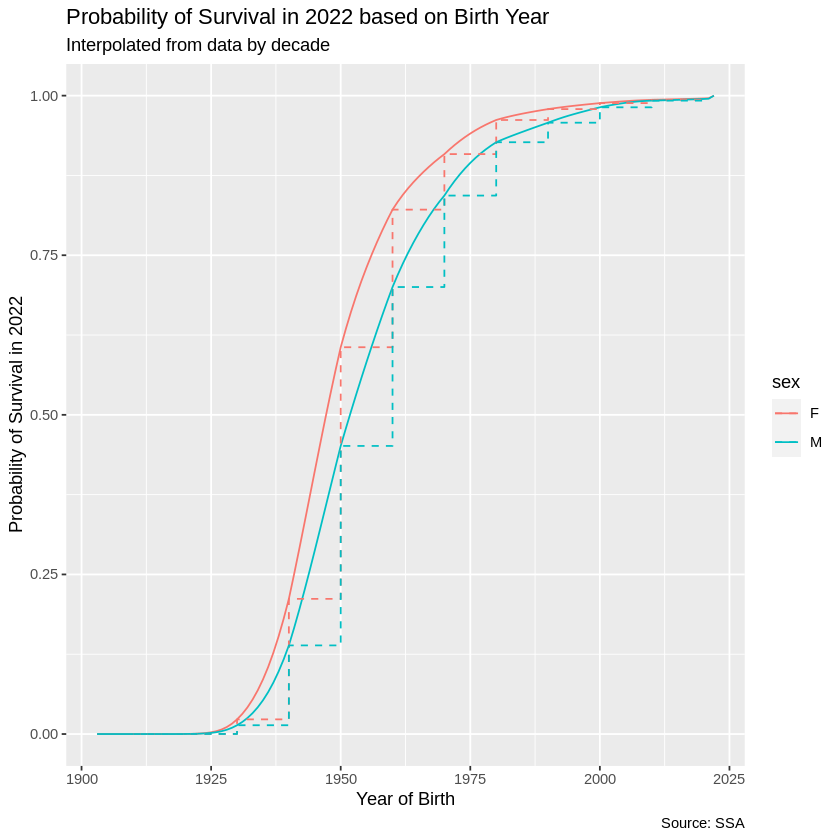

In [21]:
tbl_lifetables_extended_2022 <- tbl_lifetables_extended |> 
  filter(year + age == 2022)

tbl_lifetables_extended_2022 |> 
  # Initialize a ggplot of year vs. probability of being alive (lx/10^5)
  ggplot(aes(x = year, y = lx/10^5, color = sex)) +
  # Add a line layer
  geom_line() +
  # Add a step layer for the non-imputed data
  geom_step(
    data = function(d) filter(d, !is_imputed),
    linetype = 'dashed'
  ) +
  # Add labels (title, subtitle, x, y, caption)
  labs(
    title = "Probability of Survival in 2022 based on Birth Year",
    subtitle = "Interpolated from data by decade",
    caption = "Source: SSA",
    x = "Year of Birth",
    y = "Probability of Survival in 2022"
  )
  # Update theme to move plot title
  theme(plot.title.position = 'plot')

Note how imputing the data provides more realistic estimates of the probabilities as seen by comparing the smooth curve with the steps.

#### Combine Data

Let us now join `tbl_names` with `tbl_lifetables_extended_2022` and add two extra columns that compute the probability that the person is alive and the number of people with that name who are expected to be alive in that year.

In [22]:
tbl_names_extended <- tbl_names |> 
  # Left join with `tbl_lifetables_extended_2022` by `sex` and `year`.
  left_join(tbl_lifetables_extended_2022, by = c("sex", "year")) |> 
  # Remove any NAs in the age column
  filter(!is.na(age)) |> 
  # Add NEW column p_alive (= lx / 10^5) for probability of being alive
  mutate(p_alive = lx / 10^5) |> 
  # Remove the column `lx`
  select(!lx) |> 
  # Add NEW column nb_alive (= p_alive * nb_births) for number of people alive 
  mutate(nb_alive = p_alive * nb_births)

head(tbl_names_extended)

year,name,sex,nb_births,age,is_imputed,p_alive,nb_alive
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
1903,Mary,F,14275,119,TRUE,0,0
1903,Helen,F,6129,119,TRUE,0,0
1903,Anna,F,5098,119,TRUE,0,0
1903,Margaret,F,5046,119,TRUE,0,0
1903,Ruth,F,4517,119,TRUE,0,0
1903,Elizabeth,F,3724,119,TRUE,0,0


### Estimate Age

We now want to figure out the probability that a randomly selected person with a certain name is alive, as well as the quantiles of their age distribution. In particular, we will estimate the age of a female named Gertrude. Any guesses on how old a person with this name is? How about a male named William?

We will start by writing a function that estimates the quantiles of the age distribution for people with a given name and sex.

In [23]:
pkgs <- c("Hmisc", "janitor", "zoo")
options(repos = c(CRAN = "https://packagemanager.rstudio.com/cran/latest"))
install.packages(pkgs)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [24]:
# Function to estimate age statistics
estimate_age_stats <- function(tbl) {
  tbl |>
    summarize(
      # Age Quantiles
      stats = list(Hmisc::wtd.quantile(age, nb_alive)),
      # Probability of being alive
      p_alive = sum(nb_alive) / sum(nb_births),
      # Median Age: Weighted mean of age and nb_alive
      age_median = weighted.mean(age, nb_alive),
      .groups = "drop"
    ) |> 
    # Unnest the `stats` column so it stretches wide
    unnest_wider(stats)
}

tbl_names_extended |> 
  # Filter for Gertrude/F
  dplyr::filter(name == "Gertrude", sex == "F") |>
  # Estimate age stats
  estimate_age_stats()

0%,25%,50%,75%,100%,p_alive,age_median
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,63,72,79,106,0.06586627,68.19331


Let us write another function that plots the age distribution for a person based on their `name` and `sex`. We can then use this function to visualize the age distribution for people with different names.

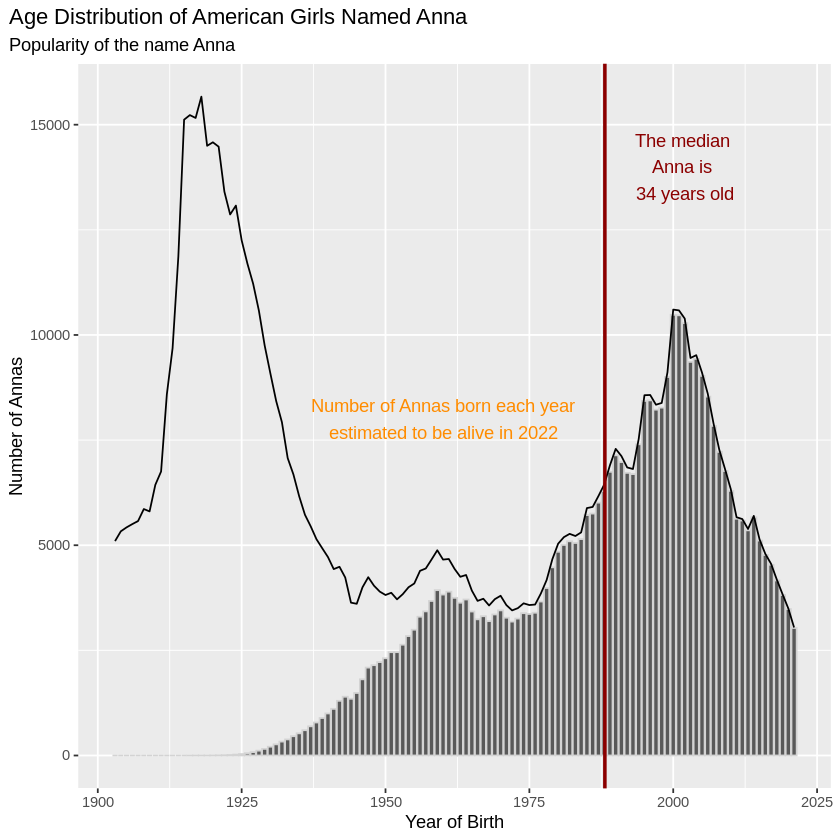

In [35]:
plot_estimated_age <- function(tbl, my_name, my_sex) {
  tbl |> 
    # Filter to keep only rows with `my_name` and `my_sex`
    filter(name == my_name, sex == my_sex) |> 
    # Add a column `age_median` with the weighted mean of age and nb_alive
    mutate(age_median = weighted.mean(age, nb_alive)) |> 
    # Initialize a ggplot with x = year
    ggplot(aes(x = year)) +
    # Add a column layer with y = nb_alive, and appropriate colors
    geom_col(aes(y = nb_alive), color = "lightgray") +
    # Add a line layer with y = nb_births, and appropriate colors
    geom_line(aes(y = nb_births), color = "black") +
    # Add a vertical line for the median age
    geom_vline(
      aes(xintercept = 2022 - age_median), 
      color = 'darkred',
      linewidth = 1
    ) +
    # Add labels (title, subtitle, x, y)
    labs(
      title = glue::glue('Age Distribution of American Girls Named {my_name}'),
      subtitle = glue::glue('Popularity of the name {my_name}'),
      x = "Year of Birth",
      y = glue::glue('Number of {my_name}s')
    ) +
    # Add an annotation for number of people estimated to be alive
    annotate(
      geom = 'text',
      x = 1960,
      y = 8000,
      label = glue::glue(
        "Number of {my_name}s born each year\nestimated to be alive in 2022"
      ),
      color = 'darkorange'
    ) +
    # Add an annotation for median age.
    geom_text(
      data = function(x) {head(x, 1)},
      x = 2002,
      y = 14000,
      aes(label = glue::glue(
        "The median \n {name} is \n {round(age_median, 0)} years old"
      )),
      color = 'darkred'
    ) +
    # Update theme to move plot title
    theme(plot.title.position = 'plot')
}

tbl_names_extended |> 
  plot_estimated_age("Anna", "F")

Let us now get the top 25 most popular names for Females.

In [41]:
# Create `tbl_names_female_top_25` with name and sex for top 25 females
tbl_names_female_top_25 <- tbl_names |>
  # Group by sex and name
  group_by(sex, name) |>
  # Summarize total number of births
  summarize(nb_births = sum(nb_births)) |>
  # Remove column nb_births
  
  # Filter only Females
  filter(sex == "F") |>
  # Slice top 25 rows
  slice_max(nb_births, n = 25) |>
  # Select name and sex
  select(name, sex)

# Print `tbl_names_female_top_25`
tbl_names_female_top_25

`summarise()` has grouped output by 'sex'. You can override using the `.groups`
argument.


name,sex
<chr>,<chr>
Mary,F
Elizabeth,F
Patricia,F
Jennifer,F
Linda,F
Barbara,F
Margaret,F
Susan,F
Dorothy,F


Let us join `tbl_names_extended` with `tbl_names_female_top_25` so that we only keep rows corresponding to the top 25 female names.

In [43]:
tbl_names_extended_age <- tbl_names_extended |> 
  # Inner join the `tbl_names_female_top_25` table by `sex` and `name`
  inner_join(tbl_names_female_top_25, by = c("sex", "name")) |>
  # Group by name and sex
   group_by(sex, name) |>
  # Estimate age stats
  estimate_age_stats() |> 
  # Arrange the data based on median age
   arrange(age_median) |>
  # Clean the names
  janitor::clean_names()

head(tbl_names_extended_age)

sex,name,x0_percent,x25_percent,x50_percent,x75_percent,x100_percent,p_alive,age_median
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F,Emily,1,16,24,33,104.2158,0.9096618,25.24575
F,Ashley,1,24,31,36,90.4776,0.9789337,29.48537
F,Anna,1,18,29,48,105.8257,0.5066154,33.87851
F,Jessica,1,29,35,40,104.5037,0.9682196,33.93706
F,Sarah,1,25,34,42,104.3929,0.8174620,34.27758
F,Elizabeth,1,24,39,57,105.4960,0.6646696,39.81726


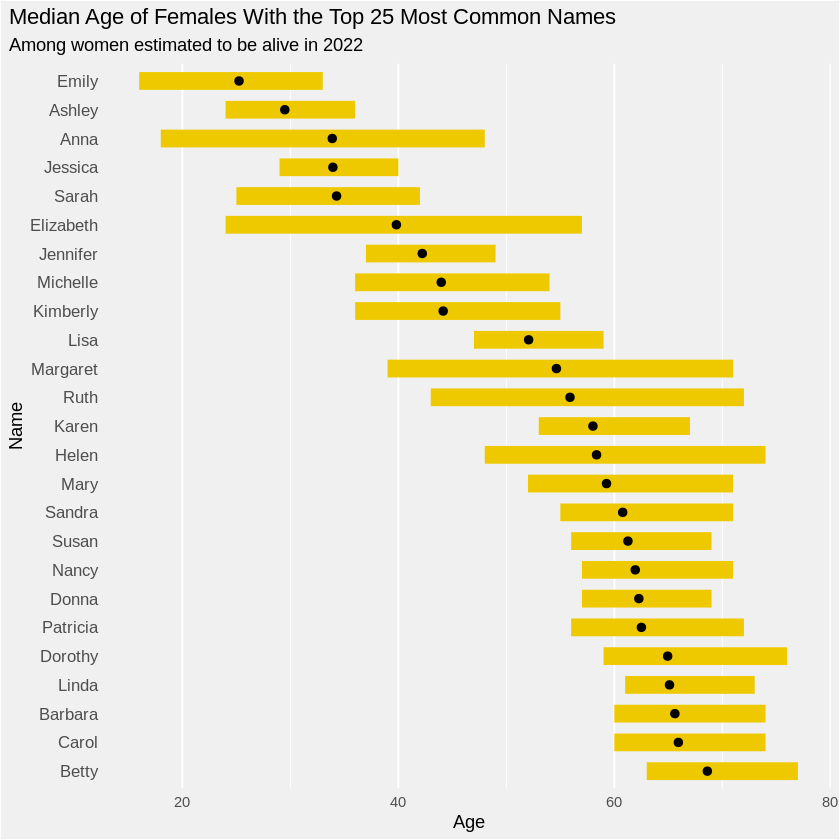

In [72]:
tbl_names_extended_age |> 
  # Reorder name based on descending median age 
  mutate(name = fct_reorder(name, desc(age_median))) |> 
  # Initialize a ggplot of age_median vs. name
  ggplot(aes(x = age_median, y = name)) +
  # Add a segment layer: x = x25_percent, xend = x75_percent and y_end = name
  geom_segment(
    aes(
      x = x25_percent,
      xend = x75_percent, 
      yend = name
    ),
    color = "gold2",
    linewidth = 5
  ) +
  # Add a point layer:
  geom_point(size = 2, color = "black") +
  # Add labels (title, subtitle, x, y)
  labs(
    title = "Median Age of Females With the Top 25 Most Common Names",
    subtitle = "Among women estimated to be alive in 2022",
    x = "Age",
    y = "Name"
  ) +
  # Update theme to clean up visual appearance of the plot
  theme(
    axis.text.y = element_text(size = 10),
    plot.title.position = 'plot',
    axis.ticks = element_blank(),
    panel.grid.major.y = element_blank(),
    plot.background = element_rect(fill = '#f0f0f0'),
    panel.background = element_rect(fill = '#f0f0f0')
  )